In [2]:
import sys
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/groups/ahrens/home/zwartm/code')
sc.addPyFile('/groups/ahrens/home/zwartm/code/fileTools.py')
sc.addPyFile('/groups/ahrens/home/zwartm/code/volTools.py')
sc.addPyFile('/groups/ahrens/home/zwartm/code/tifffile.py')
sc.addPyFile('/groups/ahrens/home/zwartm/code/compress.py')
sc.addPyFile('/groups/ahrens/home/zwartm/code/conversion.py')
import thunder as td
from registration import CrossCorr
from regression import LinearRegression, FastLinearRegression
from skimage.io import imread, imsave

import conv as conv
import volTools as volt
from volTools import proj_plot
import ablationTools as abla
import compress as compress
from skimage.external import tifffile
from fileTools import stack_to_tif, im_loader, insort, coordinates,coordinates3D 
from dff import dff

import time
import glob, os
from os.path import split, sep
from showit import image
import scipy.stats as stats
from scipy.signal import savgol_filter as savgol

In [3]:
currExp = '/groups/ahrens/ahrenslab/Maarten/Data/Lightsheet/20171006/Fish4_electrop_exp_20171006_141707/'

### Convert and load data

In [ ]:
# compress stack files, generate hdf5 files
fileList = glob.glob(currExp + 'TM0*.stack')
fileList.sort()
sc.parallelize(fileList).foreach(lambda x: conver.image_conversion(x, 'h5', wipe=True)) 

In [8]:
images = glob.glob(currExp + 'TM*.h5')
images.sort()

In [4]:
dims = volt.getStackDims(currExp)
dims.reverse() #z,y,x, for Thunder 1.0

In [10]:
dat = td.images.fromlist(images, accessor=im_loader, engine=sc, npartitions=min(10000,len(images)))

### Perform registration; save and reload as binary

In [11]:
numFrames = dat.shape[0]

# length of reference, in frames
refLength = 10
# reference timerange
refR = np.array([int(numFrames) - refLength,numFrames])
# filter parameters
filt = {}
filt['filter'] = 'median'
filt['footprint'] = 3

print('Taking reference from planes ' + str(refR[0]) + ' to ' + str(refR[-1]))
print('Filter size: ' + str(filt['footprint']))

Taking reference from planes 1658 to 1668
Filter size: 3


In [12]:
# run registration on cropped data
zStart = 0 #starting plane of registration 
zEnd = 10 #ending plane
window = 200 #width and height of the registration ROI
datCrop = dat[:numFrames,zStart:zEnd,int(dims[1]/2):int(dims[1]/2) + window, int(dims[2]/3):int(dims[2]/3) + window] # take sub-stack

In [15]:
reference = datCrop[refR[0]:refR[1],:,:,:].mean().toarray()
register = CrossCorr(axis = 0) 
model = register.fit(datCrop.median_filter(3), reference=reference)
deltas = model.toarray()

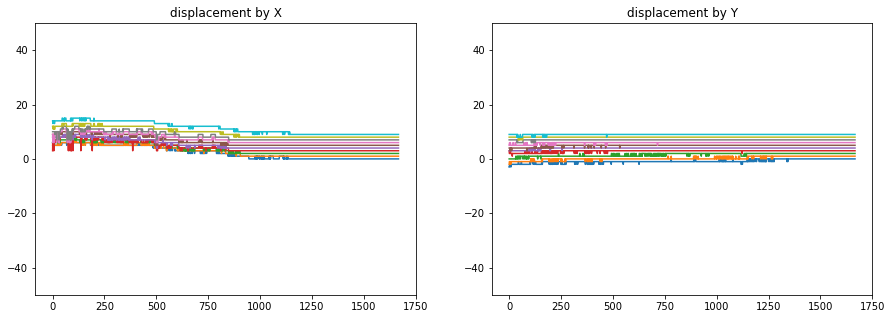

In [16]:
f, axarr = plt.subplots(1, 2,figsize=(15,5))
for x in range(deltas.shape[1]):
    axarr[0].plot(deltas[:,x,1] + x + zStart)   
    axarr[0].set_title('displacement by X')
    axarr[0].set_ylim(-50,50)

    axarr[1].plot(deltas[:,x,0] + x + zStart)  
    axarr[1].set_title('displacement by Y')
    axarr[1].set_ylim(-50,50)

In [17]:
# set registration shifts
xshift = np.floor(np.median(deltas[:,:,1],axis=1))
yshift = np.floor(np.median(deltas[:,:,0],axis=1))

for ti in range(len(model.transformations)):
    model.transformations[(ti,)].delta = []
    for zi in range(dims[0]):
        model.transformations[(ti,)].delta.append([yshift[ti],xshift[ti]])

# apply registration to full data    
datRegistered = model.transform(dat[:numFrames,:,:,:])
datRegistered.shape

(1668, 11, 700, 768)

In [5]:
procDir = currExp + '/procDir/'
if not os.path.exists(procDir):
        os.mkdir(procDir)

In [ ]:
datRegistered.tobinary(procDir + '/RegisteredData/', overwrite=True)

In [6]:
datRegistered = td.images.frombinary(procDir + '/RegisteredData', npartitions=10000, engine=sc)

In [20]:
datRegistered.shape

(1668, 11, 700, 768)

In [7]:
x,y,z = 364,286,8

radius = 5
datAbdL = datRegistered[:,z,y-radius:y+radius,x-radius:x+radius].toarray().mean(axis=(1,2))

x2,y2,z2 = 200,200,8
datAbdR = datRegistered[:,z2,y2-radius:y2+radius,x2-radius:x2+radius].toarray().mean(axis=(1,2))


In [8]:
imSeries = datRegistered.toseries().cache()

In [9]:
freq = volt.getStackFreq(currExp)[0]
index = int(freq * 5)

In [10]:
regressors = np.column_stack((datAbdL,datAbdR))
regressors.shape

(1668, 2)

In [11]:
%%time
model = FastLinearRegression(fit_intercept=False).fit(regressors, imSeries)

CPU times: user 1.85 ms, sys: 0 ns, total: 1.85 ms
Wall time: 2.18 ms


In [12]:
results = model.betas_and_scores.toarray()

In [15]:
betas, stats = results[:,:,:, 1:3], results[:,:,:, 3]

In [14]:
results.shape

(11, 700, 768, 4)

In [16]:
imAbdL = (betas[:,:,:,0]*stats)
imAbdR = (betas[:,:,:,1]*stats)

In [17]:
betas.shape

(11, 700, 768, 2)

(-1, 1)

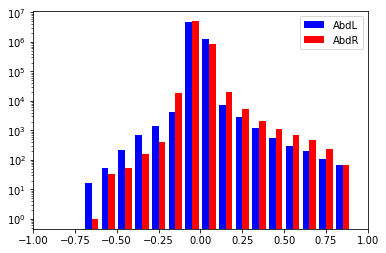

In [18]:
# check, histograms of (betas x R2)
out = plt.hist([ imAbdL.flatten(), imAbdR.flatten()],np.arange(-1,1,0.1), log = True, \
               color = ['blue', 'red'],\
               label=['AbdL', 'AbdR'])
plt.legend()
plt.xlim([-1, 1])

In [25]:
imAbdL.shape

(11, 700, 768)

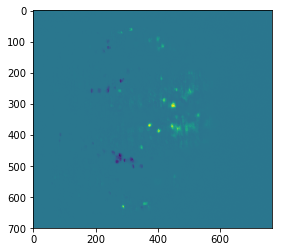

In [26]:
plt.imshow(imAbdL[0,:,:])

In [28]:
imTiffAbdL = imAbdL * 10
tifffile.imsave(procDir + 'imAbdLgamma_gamma0.5.tif',imTiffAbdL.astype(np.uint16))

imTiffAbdR = imAbdR * 10
tifffile.imsave(procDir + 'imAbdRgamma_gamma0.5.tif',imTiffAbdR.astype(np.uint16))